In [50]:
import torch
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# following: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

# Read data
T = 5
path = f"..\\data\\data_T{str(T)}.csv"
names = ['time', 'x1' , 'x2','obs_num']
df = pd.read_csv(path,sep=',', header=0, names=names,index_col=False)
print(df.head())
print(df.shape)

obs = max(df['obs_num'])
print("Number of different trajectory functions",int(obs))



       time        x1          x2  obs_num
0  0.000000  0.000000    0.000000      1.0
1  0.102041  0.528525  137.491450      1.0
2  0.204082  1.057050  265.172900      1.0
3  0.306122  1.585575  383.044351      1.0
4  0.408163  2.114100  491.105801      1.0
(250, 4)
Number of different trajectory functions 5


In [51]:
# Train test split

train_data = df[df['time']< (0.7 * T)]
test_data = df[df['time']>= (0.7 * T)]
print("train shape, test shape: ",train_data.shape, test_data.shape)
print(train_data.head())

train_times = df[df['time']< (0.7 * T)]["time"].tolist()
test_times =  df[df['time']>= (0.7 * T)]["time"].tolist()
print("train times: ", train_times)
print("test times: ", test_times)

train shape, test shape:  (175, 4) (75, 4)
       time        x1          x2  obs_num
0  0.000000  0.000000    0.000000      1.0
1  0.102041  0.528525  137.491450      1.0
2  0.204082  1.057050  265.172900      1.0
3  0.306122  1.585575  383.044351      1.0
4  0.408163  2.114100  491.105801      1.0
train times:  [0.0, 0.1020408163265306, 0.2040816326530612, 0.3061224489795918, 0.4081632653061224, 0.5102040816326531, 0.6122448979591837, 0.7142857142857143, 0.8163265306122449, 0.9183673469387756, 1.020408163265306, 1.1224489795918369, 1.2244897959183674, 1.326530612244898, 1.4285714285714286, 1.530612244897959, 1.6326530612244898, 1.7346938775510203, 1.836734693877551, 1.9387755102040816, 2.0408163265306123, 2.142857142857143, 2.2448979591836737, 2.346938775510204, 2.4489795918367347, 2.5510204081632653, 2.653061224489796, 2.7551020408163267, 2.857142857142857, 2.959183673469388, 3.0612244897959187, 3.163265306122449, 3.26530612244898, 3.36734693877551, 3.4693877551020407, 0.0, 0.102040

In [52]:
scaler = MinMaxScaler(feature_range=(0, 1)) # StandardScaler() # 

# Scaling dataset
scaled_train = scaler.fit_transform(train_data.to_numpy())
scaled_train = pd.DataFrame(scaled_train, columns=names)
print(scaled_train.shape)
print(scaled_train.head())

scaled_test = scaler.fit_transform(test_data.to_numpy())
scaled_test = pd.DataFrame(scaled_test, columns=names)
print(scaled_test.shape)


(175, 4)
       time        x1        x2  obs_num
0  0.000000  0.000000  0.840553      0.0
1  0.029412  0.015658  0.861789      0.0
2  0.058824  0.031316  0.881510      0.0
3  0.088235  0.046974  0.899716      0.0
4  0.117647  0.062632  0.916406      0.0
(75, 4)


In [53]:
# define positional encoding
# def positional_encoding(T, d_model):
#     # Initialize positional encoding matrix
#     t= np.linspace(0, 1, num=T)
#     pe = np.zeros((t.shape[0], d_model))
    
#     # Compute positional encodings
#     for pos, time in enumerate(t):
#         for i in range(d_model):
#             if i % 2 == 0:
#                 pe[pos, i] = np.sin(time / (10000 ** (2 * i / d_model)))
#             else:
#                 pe[pos, i] = np.cos(time / (10000 ** (2 * (i-1) / d_model)))
    
#     return np.array(pe)



# ## Save data
# ID = []
# PE = []
# d_model  = 1
# N = 10

# for i in range(N):
#     PE += [positional_encoding(T-1, d_model)[:,d_model-1]]

# PE = np.array(PE)
# print(PE)
# PE= PE.flatten()
# print(PE.shape)

In [54]:
# PE_train = PE[:training_data_len]
# PE_test  = PE[training_data_len:]

# scaled_train["u"] = scaled_train["u"] + PE_train
# scaled_train["dx_dt"] = scaled_train["dx_dt"] + PE_train

# scaled_test["u"] = scaled_test["u"] + PE_test
# scaled_test["dx_dt"] = scaled_test["dx_dt"] + PE_test

# print(scaled_train.head())
# print(scaled_test.head())

In [73]:
# Create sequences
def to_sequences(seq_size, df, pred_len):
    x = []
    y = []
    times_x = []
    times_y = []
    
    overlap = seq_size - pred_len
    for obs in df['obs_num'].unique():
        df_obs = df[df['obs_num']==obs]
        obs_x1 = df_obs['x1'].tolist()
        obs_x2 = df_obs['x2'].tolist()
        t = df_obs['time'].tolist()
        for i in range((len(obs_x1))-seq_size-pred_len) : #create input and pred windows based on trajectory function
            
            window1 = obs_x1[i:(i+seq_size)]  # x at time t
            window2 = obs_x2[i:(i+seq_size)]  # u at time t
            t_x = t[i:(i+seq_size)]
        
            after_window1 = obs_x1[i+seq_size-overlap : i+seq_size+pred_len]  # delta x at time t+1 ( x_t+1 - x_t = delta_x_t+1)
            after_window2 = obs_x2[i+seq_size-overlap : i+seq_size+pred_len]
            t_y = t[i+seq_size-overlap : i+seq_size+pred_len]
            
            window = [[x, u] for x,u in zip(window1, window2)]
            after_window = [[x, u] for x,u in zip(after_window1, after_window2)]
            
            x.append(window)
            y.append(after_window)
            
            times_x.append(t_x)
            times_y.append(t_y)

    #return np.array(x).transpose((0,2,1)), np.array(y).transpose(0,2,1)
    return np.array(x), np.array(y), np.array(times_x), np.array(times_y)
pred_len = 3
sequence_size = 5

X_train, y_train, X_train_times, y_train_times = to_sequences(sequence_size, scaled_train, pred_len)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
X_test,  y_test, X_test_times, y_test_times  = to_sequences(sequence_size, scaled_test, pred_len)
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([135, 5, 2]) torch.Size([135, 5, 2])
torch.Size([35, 5, 2]) torch.Size([35, 5, 2])


In [61]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [62]:
# class TransformerModel(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3):
#         super(TransformerModel, self).__init__()
#         self.model_type = 'Transformer'
#         self.linear1 = torch.nn.Linear(input_dim, d_model)
#         self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
#                                           num_encoder_layers=num_encoder_layers,
#                                           num_decoder_layers=num_decoder_layers, batch_first=True)
#         self.linear2 = torch.nn.Linear(d_model, output_dim)

#     def forward(self, src, tgt, sequence_size):
#         src = self.linear1(src)
#         tgt = self.linear1(tgt)
        
#         src_mask = self.transformer.generate_square_subsequent_mask(sequence_size)
#         output = self.transformer(src, tgt, src_mask)
#         output = self.linear2(output)
#         return output
from Tmodel import TransformerModel

# Instantiate the model
input_dim = 2  
output_dim = 2  
model = TransformerModel(input_dim, output_dim)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [63]:
# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs, targets, sequence_size)
        loss = criterion(output, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    # Early stopping if the loss is low enough
    if avg_loss <= 0.0001:
        print("Training stopped early, loss is below 0.01.")
        break


Epoch 1/1200, Loss: 1.4548
Epoch 2/1200, Loss: 0.2009
Epoch 3/1200, Loss: 0.1004
Epoch 4/1200, Loss: 0.0633
Epoch 5/1200, Loss: 0.0604
Epoch 6/1200, Loss: 0.0509
Epoch 7/1200, Loss: 0.0577
Epoch 8/1200, Loss: 0.0534
Epoch 9/1200, Loss: 0.0537
Epoch 10/1200, Loss: 0.0514
Epoch 11/1200, Loss: 0.0552
Epoch 12/1200, Loss: 0.0518
Epoch 13/1200, Loss: 0.0476
Epoch 14/1200, Loss: 0.0497
Epoch 15/1200, Loss: 0.0473
Epoch 16/1200, Loss: 0.0354
Epoch 17/1200, Loss: 0.0313
Epoch 18/1200, Loss: 0.0260
Epoch 19/1200, Loss: 0.0158
Epoch 20/1200, Loss: 0.0136
Epoch 21/1200, Loss: 0.0147
Epoch 22/1200, Loss: 0.0123
Epoch 23/1200, Loss: 0.0104
Epoch 24/1200, Loss: 0.0109
Epoch 25/1200, Loss: 0.0118
Epoch 26/1200, Loss: 0.0117
Epoch 27/1200, Loss: 0.0100
Epoch 28/1200, Loss: 0.0091
Epoch 29/1200, Loss: 0.0092
Epoch 30/1200, Loss: 0.0087
Epoch 31/1200, Loss: 0.0090
Epoch 32/1200, Loss: 0.0078
Epoch 33/1200, Loss: 0.0075
Epoch 34/1200, Loss: 0.0089
Epoch 35/1200, Loss: 0.0083
Epoch 36/1200, Loss: 0.0077
E

In [64]:

# Evaluate the model
model.eval()
outputs = []
with torch.no_grad():
    output = model(X_test, X_test, sequence_size)
    outputs += output
    test_loss = criterion(output, y_test)
    print(f'Test MSE Loss: {test_loss.item():.4f}')


Test MSE Loss: 0.0049


In [65]:
# #save model
model_path = ".\\toy_pytorch_model.pt"
torch.save(model.state_dict(), model_path)

In [74]:
outputs = np.array(outputs)
print(y_test.shape, outputs.shape)
print(y_test_times.shape)

torch.Size([35, 5, 2]) (35, 5, 2)
(35, 5)


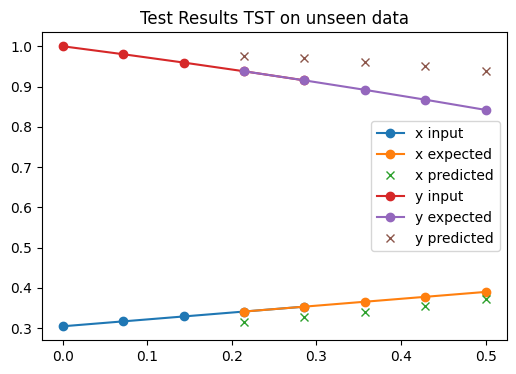

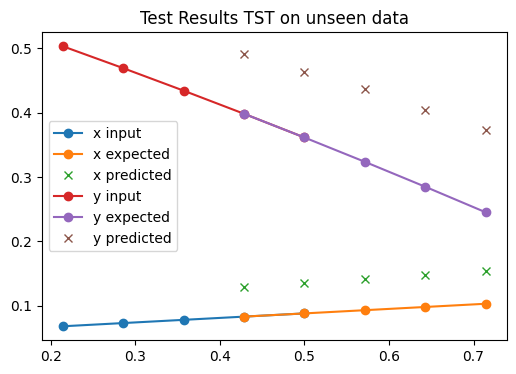

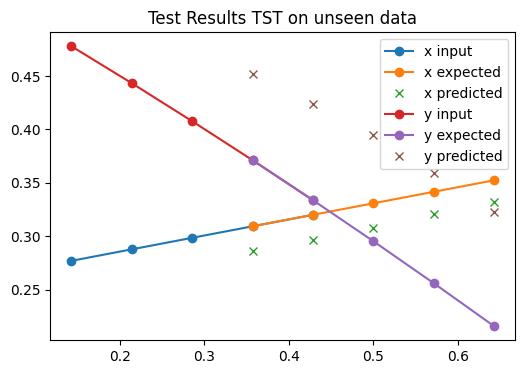

In [80]:
# display test results
import matplotlib.pyplot as plt
for i in [0, 10, 30]:
    
    plt.figure(i, figsize=(6, 4))
    plt.plot(X_test_times[i,:], X_test[i,:,0], "-o", label='x input')
    plt.plot(y_test_times[i,:], y_test[i,:,0], "-o", label='x expected')
    plt.plot(y_test_times[i,:], outputs[i,:,0] , "x", label='x predicted')
    
    plt.plot(X_test_times[i,:], X_test[i,:,1], "-o", label='y input')
    plt.plot(y_test_times[i,:],y_test[i,:,1], "-o", label='y expected')
    plt.plot(y_test_times[i,:],outputs[i,:,1] , "x", label='y predicted')
    plt.title(f"Test Results TST on unseen data")
    plt.legend()

In [ ]:
from torchinfo import summary

print(summary(model, input_data=(X_test, X_test, sequence_size)))

Layer (type:depth-idx)                             Output Shape              Param #
TransformerModel                                   [55, 10, 2]               --
├─Linear: 1-1                                      [55, 10, 64]              192
├─Linear: 1-2                                      [55, 10, 64]              (recursive)
├─Transformer: 1-3                                 [55, 10, 64]              --
│    └─TransformerEncoder: 2-1                     [55, 10, 64]              --
│    │    └─ModuleList: 3-1                        --                        843,456
│    │    └─LayerNorm: 3-2                         [55, 10, 64]              128
│    └─TransformerDecoder: 2-2                     [55, 10, 64]              --
│    │    └─ModuleList: 3-3                        --                        893,760
│    │    └─LayerNorm: 3-4                         [55, 10, 64]              128
├─Linear: 1-4                                      [55, 10, 2]               130
Total params